Necessary imports:

In [ ]:
import csv
import requests
import json
import urllib.request
import os
from bs4 import BeautifulSoup
import pandas as pd
from IPython.display import clear_output
import matplotlib.pyplot as plt
from threading import Thread
from nltk.corpus import stopwords
dutch_stopwords = stopwords.words("dutch")

# Court Case Scraper

### Config

In [2]:
query = 'drugs'
base_verdicts_url = 'https://uitspraken.rechtspraak.nl/api/zoek' 
complete_case_url = 'https://uitspraken.rechtspraak.nl/inziendocument?id='
case_count = 10000000 ## Amount of cases to retrieve. If you want max, just do an insanely high number, it stops when it fetched all cases. Backend does not accept values like 'max'.
save_text_location = os.getcwd() + '/court case data/testdata/' # You have to have created this folder first. 
cases_df = pd.DataFrame()

index = ["id", "verdict_date", "publication_date", "verdict_type", "jurisdiction_type"]


files = {
        "StartRow": 0,
        "PageSize": case_count,
        "ShouldReturnHighlights":'true',
        "ShouldCountFacets":'true',
        "SortOrder":"Relevance",
        "SearchTerms":[{"Term":query,"Field":"AlleVelden"}],
        "Contentsoorten":[],
        "Rechtsgebieden":[],
        "Instanties":[],
        "DatumPublicatie":[],
        "DatumUitspraak":[],
        "Advanced":{"PublicatieStatus":"AlleenGepubliceerd"},
        "CorrelationId":"9abc658b0ce64f8786992af6965aabc4",
        "Proceduresoorten":[]
    }


### Old Methods

Method to extract the text from the casefiles. Search the uitsprakenBaseURL with case ID to get the html file. 
Filter through the html file with BeautifulSoup and look for either class 'uitspraak' or 'conclusie' as the standard seems to switch between cases. 
Parse html file to textfile to get a clean text file. Replace \n and commas with empty strings.

In [4]:
def getCaseText(caseId):
    response = requests.get(uitsprakenBaseUrl + caseId)
    soup = BeautifulSoup(response.text, 'html.parser')
    soup_content = soup.find("div", {"id": 'content'})
    uitspraak_html = soup_content.find('div', {'class': 'uitspraak'})
    if soup_content.find('div', {'class': 'uitspraak'}) is not None:
        uitspraak_html = soup_content.find('div', {'class': 'uitspraak'})
    elif soup_content.find('div', {'class': 'conclusie'}) is not None:
        uitspraak_html =  soup_content.find('div', {'class': 'conclusie'})
    uitspraak = uitspraak_html.get_text()
    uitspraak = uitspraak.replace(',', '')
    return uitspraak

Method to parse each case individually. Save case attributes to cases.csv and save each case text to a .txt file in /data/ folder and name it the case ID.

In [5]:
def parseCaseInfo(results):
    global cases_df
    for case in results:
        caseText = getCaseText(case['TitelEmphasis'])
        parsedId = case['TitelEmphasis'].replace(':', '-') # Case id's apparentlyl use ':'. We cannot save files with ':' in the name, so we replace them with '-'.
        f= open(save_text_location + parsedId + ".txt","w+", encoding='utf-8') # Doesn't work without encoding. 
        f.write(caseText)
        case['Case ID'] = parsedId
        cases_df = cases_df.append(case, ignore_index = True)
        print('Processed case', case['Case ID'])
    cases_df.to_csv('cases3.csv', index=False)

Method to retrieve raw data from the backend. Backend url is at the top in the Config. files = complete request payload the backend expects to receive. 


In [ ]:
def queryUitspraak():
    print("Querying")
    files = {
        "StartRow": 0,
        "PageSize": case_count,
        "ShouldReturnHighlights":'true',
        "ShouldCountFacets":'true',
        "SortOrder":"Relevance",
        "SearchTerms":[{"Term":searchQuery,"Field":"AlleVelden"}],
        "Contentsoorten":[],
        "Rechtsgebieden":[],
        "Instanties":[],
        "DatumPublicatie":[],
        "DatumUitspraak":[],
        "Advanced":{"PublicatieStatus":"AlleenGepubliceerd"},
        "CorrelationId":"9abc658b0ce64f8786992af6965aabc4",
        "Proceduresoorten":[]
    }
    try:
        response = requests.post(baseUrl, json=files)
        responseJSON = json.loads(response.text)
        results = responseJSON['Results']
        print(len(results), "records!")
        parseCaseInfo(results)
    except urllib.error.HTTPError as err:
        print(err) 

queryUitspraak()

### Methods

Get cases from https://uitspraken.rechtspraak.nl/api/zoek.
Returns a collection of dictionaries.

In [3]:
def get_cases(config):
    try:
        response = requests.post(base_verdicts_url, json=config)
        responseJSON = json.loads(response.text)
        results = responseJSON['Results']
        print(len(results), "records found.")
        return results
    except urllib.error.HTTPError as err:
        print(err)   

Create a dataframe of all queried cases with the following columns: 
- Id
- Verdict date
- Publication date
- Verdict type
- Jurisdiction type

In [4]:
def create_cases_df(cases):
    cases_df = pd.DataFrame(columns = index)
    cases_df = pd.DataFrame(columns = index)
    for case in cases:
        curr_case = pd.Series([case["TitelEmphasis"].replace(":", "-"), case["Uitspraakdatum"], case["Publicatiedatum"], case["UitspraakdatumType"], case["Rechtsgebieden"]], index = index)
        cases_df = cases_df.append(curr_case, ignore_index=True)
    cases_df.to_csv('./court case data/testdata.csv', index=False)
    return cases_df
            

Save the text of all cases from the dataframe to a .txt file located in /data folder. 

In [5]:
def save_case_text(df):
    case_count = len(df)
    i = 1
    for case in df["id"]:
        try:
            response = requests.get(complete_case_url + case.replace("-", ":"))
            soup = BeautifulSoup(response.text, 'html.parser')
            soup_content = soup.find("div", {"id": 'content'})
            uitspraak_html = soup_content.find('div', {'class': 'uitspraak'})
            if soup_content.find('div', {'class': 'uitspraak'}) is not None:
                uitspraak_html = soup_content.find('div', {'class': 'uitspraak'})
            elif soup_content.find('div', {'class': 'conclusie'}) is not None:
                uitspraak_html =  soup_content.find('div', {'class': 'conclusie'})
            uitspraak = uitspraak_html.get_text()
            uitspraak = uitspraak.replace(',', '')
            parsed_id = case.replace(":", "-")
            f= open(save_text_location + parsed_id + ".txt","w+", encoding='utf-8') # Doesn't work without encoding. 
            f.write(uitspraak)
#             print(f"{i}/{case_count} {parsed_id}")
#             clear_output(wait=True)
#             i += 1
        except Exception as e:
            print(f"Error in saving. {e}")
    print("Finished")
            

### Create dataset

In [6]:
cases = get_cases(files)
cases_df = create_cases_df(cases)
# save_case_text(cases_df)


17968 records found.


In [329]:
%%time
save_case_text(cases_df)

Finished
CPU times: user 6.31 s, sys: 278 ms, total: 6.59 s
Wall time: 39.4 s


In [7]:
%%time
cases_df_1 = cases_df[:5000]
cases_df_2 = cases_df[5000:10000]
cases_df_3 = cases_df[10000:15000]
cases_df_4 = cases_df[15000:]

print(len(cases_df_1))
print(len(cases_df_2))

t1 = Thread(target=save_case_text ,args=(cases_df_1,))
t2 = Thread(target=save_case_text ,args=(cases_df_2,))
t3 = Thread(target=save_case_text ,args=(cases_df_3,))
t4 = Thread(target=save_case_text ,args=(cases_df_4,))


t1.start()
t2.start()
t3.start()
t4.start()

t1.join()
t2.join()
t3.join()
t4.join()
print("finished")

5000
5000
Finished
Finished
Finished
Finished
finished
CPU times: user 16min 51s, sys: 36.2 s, total: 17min 27s
Wall time: 44min 22s


### Create and clean full dataframe

Create:

In [2]:
dataPath = os.getcwd() + '/court case data/testdata/'
caseCount = len(os.listdir(dataPath))
data = []
try:
    os.remove(dataPath + ".DS_Store")
except:
    print("No file DS_Store")
for filename in os.listdir(dataPath):
    f = open(os.path.join(dataPath, filename), encoding='utf-8')
    data.append([filename.replace('.txt', ''), f.read()])

verdict_df = pd.DataFrame(data, columns=["id", "case text"])
cases_df = pd.read_csv('./court case data/testdata.csv')
merged_df = cases_df.join(verdict_df.set_index('id'), on='id', how='left')

merged_df["verdict_date"] = pd.to_datetime(merged_df["verdict_date"])
merged_df["publication_date"] = pd.to_datetime(merged_df["publication_date"])


No file DS_Store


Clean:

In [3]:
total_len_uncleaned = 0
for i in range(len(merged_df)):
    currtext = merged_df.iloc[i]["case text"]
    length = len(currtext.split())
    total_len_uncleaned += length

In [7]:
cleaned_df = merged_df.copy()
cleaned_df['case text'] = cleaned_df['case text'].apply(lambda x: ' '.join([word for word in x.split() if word not in dutch_stopwords]))


In [8]:
total_len_cleaned = 0
for i in range(len(cleaned_df)):
    currtext = cleaned_df.iloc[i]["case text"]
    length = len(currtext.split())
    total_len_cleaned += length

In [9]:
print(f"Original count: {total_len_uncleaned} \n Cleaned count: {total_len_cleaned} \n Difference: {total_len_uncleaned - total_len_cleaned}")
print(f"{round((total_len_uncleaned - total_len_cleaned) / total_len_uncleaned * 100, 2)}% decrease")


Original count: 84851468 
 Cleaned count: 50816927 
 Difference: 34034541
40.11% decrease


### 

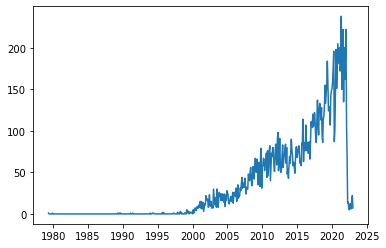

In [11]:
dateplot = cleaned_df['verdict_date'].value_counts().resample('1M').sum()
plt.plot(dateplot)

Copy merged_df to cleaned_df and remove stopwords

### 

# Dutch News Articles

### Import Data

In [46]:
nos_df = pd.read_csv('./NOS articles/dutch-news-articles.csv')
nos_df["datetime"] = pd.to_datetime(nos_df["datetime"])

In [310]:
print(nos_df["category"].unique())

['Buitenland' 'Binnenland' 'Politiek' 'Economie' 'Koningshuis'
 'Opmerkelijk' 'Tech' 'Cultuur & Media' 'Regionaal nieuws']


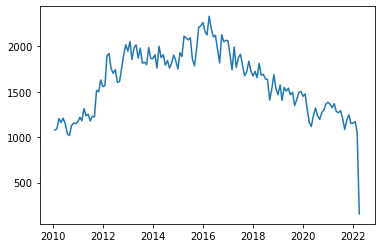

In [308]:
nos_date_plot = nos_df["datetime"].value_counts().resample("1M").sum()
plt.plot(nos_date_plot)

### Clean data

In [15]:
print(f"{len(nos_df)} articles")

word_count = 0
for i in range(len(nos_df)):
    curr = nos_df.iloc[i]
    word_count += len(curr["content"].split())
print(word_count)


237344 articles
58947842


In [16]:
cleaned_nos_df = nos_df.copy()
cleaned_nos_df['content'] = cleaned_nos_df['content'].apply(lambda x: ' '.join([word for word in x.split() if word not in dutch_stopwords]))


In [19]:
cleaned_word_count = 0
for i in range(len(cleaned_nos_df)):
    curr = cleaned_nos_df.iloc[i]
    cleaned_word_count += len(curr["content"].split())
print(cleaned_word_count)

34967964


In [20]:
print(f"Original count: {word_count} \n Cleaned count: {cleaned_word_count} \n Difference: {word_count - cleaned_word_count}")
print(f"{round((word_count - cleaned_word_count) / word_count * 100, 2)}% decrease")


Original count: 93915806 
 Cleaned count: 34967964 
 Difference: 58947842
62.77% decrease


In [33]:
print(f"Original NOS dataframe contains {len(cleaned_nos_df)} articles.")

nos_drugs_df = pd.DataFrame()
drugs_words = ["drugs", "narcotica", "verdovende middelen"]

for i in range(len(cleaned_nos_df)):
    curr = cleaned_nos_df.iloc[i]
    if any(x in curr["content"] for x in drugs_words):
        nos_drugs_df = nos_drugs_df.append(curr)
    
print(f"New drug NOS dataframe contains {len(nos_drugs_df)} articles.")

nos_trafficking_df = pd.DataFrame()
trafficking_words = ["smokkel", "transport", "invoer", "import", "export", "uitvoer"]

for i in range(len(nos_drugs_df)):
    curr = nos_drugs_df.iloc[i]
    if any(x in curr["content"] for x in trafficking_words):
        nos_trafficking_df = nos_trafficking_df.append(curr)
    
print(f"New trafficking NOS dataframe contains {len(nos_trafficking_df)} articles.")

Original NOS dataframe contains 237344 articles.
New drug NOS dataframe contains 6503 articles.
New trafficking NOS dataframe contains 1396 articles.


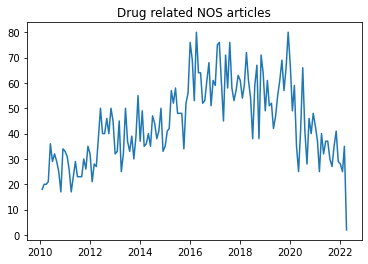

In [45]:
nos_drugs_plot = nos_drugs_df["datetime"].value_counts().resample("1M").sum()
plt.title("Drug related NOS articles")
plt.plot(nos_drugs_plot)

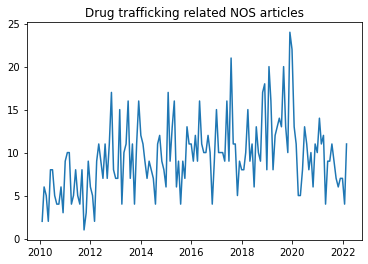

In [44]:
nos_trafficking_plot = nos_trafficking_df["datetime"].value_counts().resample("1M").sum()
plt.title("Drug trafficking related NOS articles")
plt.plot(nos_trafficking_plot)

# 